# Proyek Klasifikasi Gambar: Skin Cancer Dataset
- **Nama:** Leonard Bodhi Kumaro
- **Email:** bkleonard174@gmail.com
- **ID Dicoding:** leonardkumaro


## Introduction


Kanker kulit, khususnya melanoma, adalah salah satu jenis kanker yang paling umum dan berbahaya, dengan deteksi dini yang sangat penting untuk meningkatkan hasil pengobatan pasien. Sistem deteksi otomatis yang memanfaatkan pembelajaran mendalam dapat secara signifikan meningkatkan akurasi dan efisiensi diagnostik. Dalam proyek ini, saya mengembangkan model berbasis Convolutional Neural Network (CNN) menggunakan arsitektur canggih seperti equential CNN dengan 3 blok konvolusi dan 2 dense layer untuk mengklasifikasikan lesi kulit dari kumpulan data ISIC. Model ini menjawab tantangan utama seperti variasi warna kulit, kondisi pencahayaan, dan morfologi lesi. Dengan menerapkan teknik augmentasi data dan pembelajaran transfer, saya bertujuan untuk menciptakan pengklasifikasi yang kuat yang mampu membantu dokter kulit dalam deteksi dini melanoma.

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor library yang diperlukan
import os
import numpy as np
import pandas as pd

from PIL import Image
from glob import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization,Dropout, Dense, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display

## Data Preparation

### Data Loading

In [2]:
# Mengimpor library kagglehub untuk mengunduh dataset
import kagglehub
kmader_skin_cancer_mnist_ham10000_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')

print('Data source import complete.')

Data source import complete.


There are 5 csv files in the current version of the dataset:


In [3]:
# Mengatur direktori kerja
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0032809.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0031479.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0030506.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0031986.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0033624.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029352.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0032582.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0033152.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0033974.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0031417.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029889.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_p

### Data Preprocessing

In [4]:
# Mengatur direktori data
data_directory = os.path.join("/kaggle/input/", "skin-cancer-mnist-ham10000/")
os.listdir(data_directory)

data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))

In [5]:
# Menampilkan 5 baris pertama dari data
data.head()
# Menampilkan informasi tentang data
data.info()
# Menampilkan statistik deskriptif dari data
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [6]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())
# Menambahkan kolom cell_type dan image_path
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)


# Menambahkan piksel gambar
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
6341,HAM_0003797,ISIC_0024639,nv,follow_up,60.0,male,back,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[216, 124, 144], [218, 125, 146], [218, 122,..."
2354,HAM_0006203,ISIC_0026456,vasc,histo,60.0,male,upper extremity,Vascular lesions (vasc),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[221, 195, 198], [224, 198, 205], [223, 186,..."
9635,HAM_0004370,ISIC_0027138,nv,consensus,10.0,male,unknown,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[24, 15, 24], [43, 28, 37], [83, 61, 70], [1..."
3773,HAM_0000899,ISIC_0029708,nv,follow_up,65.0,female,upper extremity,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[215, 128, 136], [217, 129, 135], [219, 132,..."
8840,HAM_0006244,ISIC_0027627,nv,histo,45.0,female,lower extremity,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[160, 118, 129], [168, 129, 141], [174, 136,..."


In [7]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=data['sex'].value_counts().index,
            y=data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=data['localization'].value_counts().index,
            y=data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=data['dx'].value_counts().index.map(lesion_type_dict.get),
            y=data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)

fig.show()

<ipython-input-8-99d016c0a5e4>:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-8-99d016c0a5e4>:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-8-99d016c0a5e4>:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



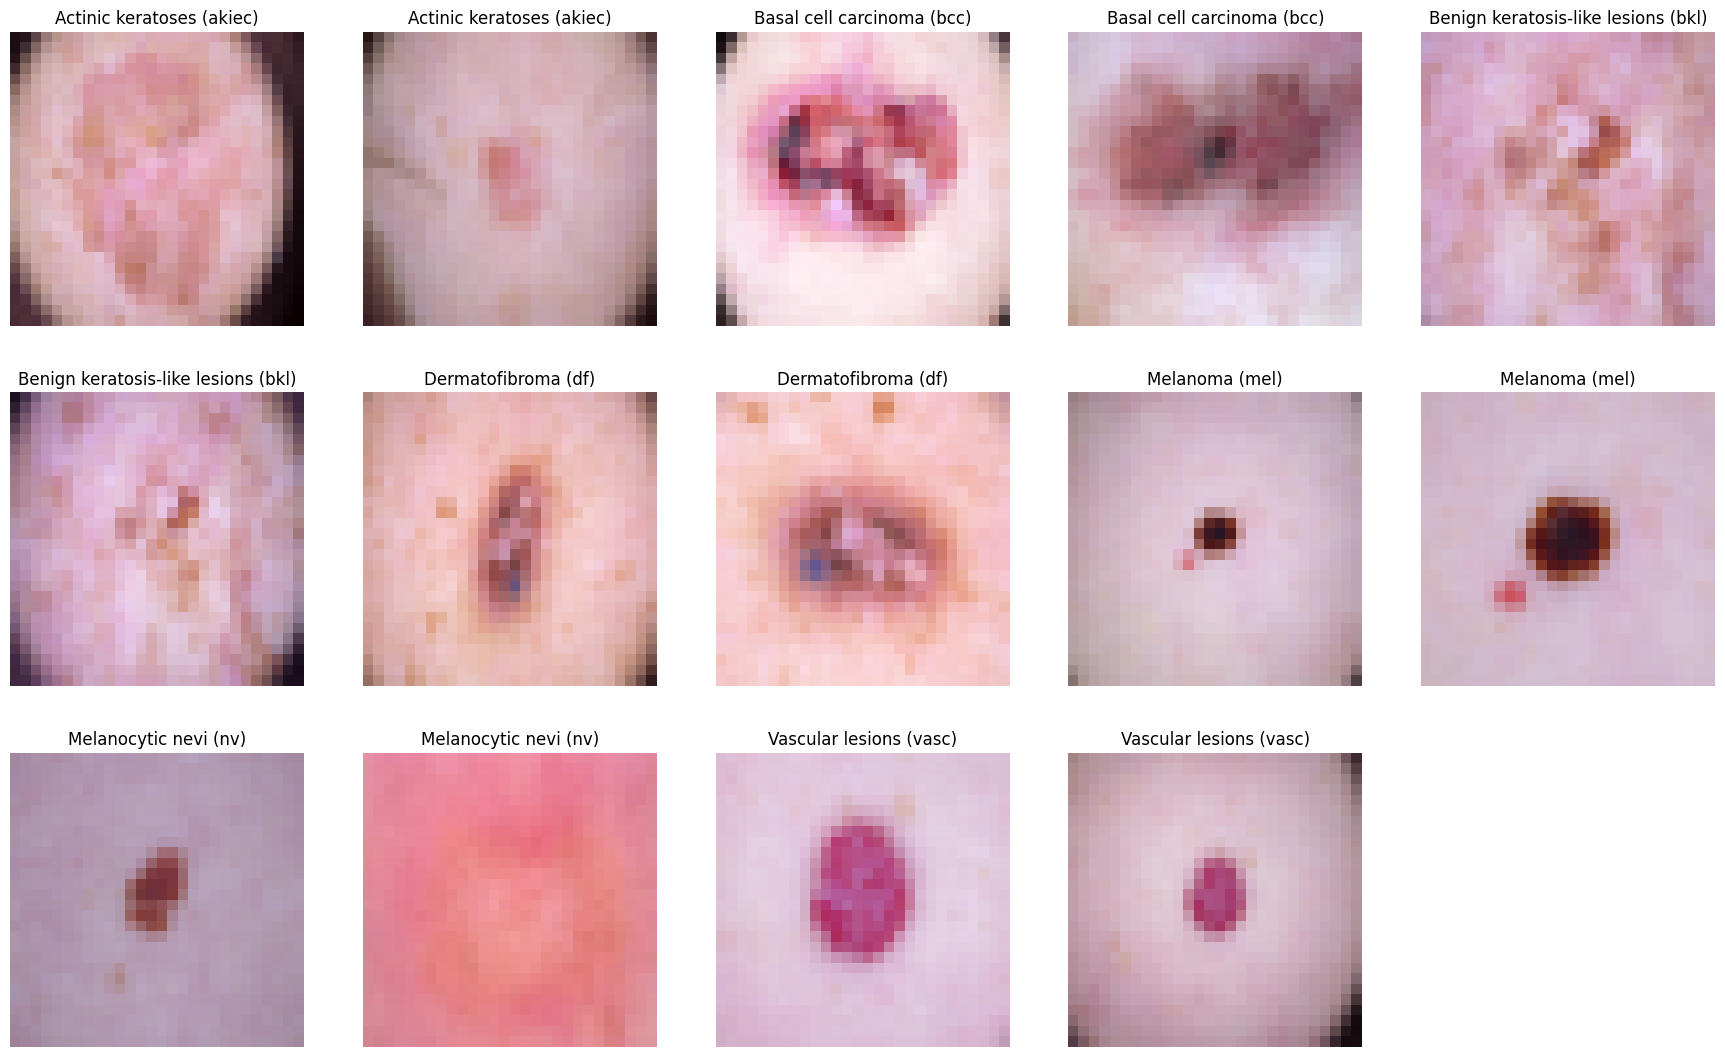

In [8]:
# Menampilkan 2 gambar untuk setiap label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show()


In [9]:
# Memeriksa nilai nol
data.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
cell_type,0
path,0
image_pixel,0


In [10]:
# Menangani nilai nol
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Mengonversi tipe data usia menjadi int32
data['age'] = data['age'].astype('int32')
# Label pengkodean gambar secara kategoris
data['label'] = data['dx'].map(reverse_label_mapping.get)
data.sample(5)

<ipython-input-10-fe81fe14e6c0>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
1886,HAM_0000169,ISIC_0032960,mel,histo,51,male,face,Melanoma (mel),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[206, 149, 184], [202, 138, 158], [208, 156,...",1
8288,HAM_0003828,ISIC_0031657,nv,histo,35,female,abdomen,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[215, 157, 175], [216, 157, 174], [219, 161,...",0
8672,HAM_0003546,ISIC_0030006,nv,histo,20,female,back,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[177, 153, 151], [181, 157, 157], [186, 164,...",0
77,HAM_0001728,ISIC_0033539,bkl,histo,60,male,back,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[25, 19, 30], [76, 60, 70], [129, 105, 106],...",2
1777,HAM_0000274,ISIC_0031479,mel,histo,75,female,lower extremity,Melanoma (mel),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[167, 153, 161], [173, 158, 166], [176, 158,...",1


### Data Augmentation

In [11]:
data = data.sort_values('label')
data = data.reset_index(drop=True)

In [12]:
index1 = data[data['label'] == 1].index.values
index2 = data[data['label'] == 2].index.values
index3 = data[data['label'] == 3].index.values
index4 = data[data['label'] == 4].index.values
index5 = data[data['label'] == 5].index.values
index6 = data[data['label'] == 6].index.values

df_index1 = data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = data.iloc[int(min(index3)):int(max(index3)+1)]
df_index4 = data.iloc[int(min(index4)):int(max(index4)+1)]
df_index5 = data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = data.iloc[int(min(index6)):int(max(index6)+1)]

df_index1 = pd.concat([df_index1] * 5, ignore_index=True)
df_index2 = pd.concat([df_index2] * 5, ignore_index=True)
df_index3 = pd.concat([df_index3] * 12, ignore_index=True)
df_index4 = pd.concat([df_index4] * 18, ignore_index=True)
df_index5 = pd.concat([df_index5] * 46, ignore_index=True)
df_index6 = pd.concat([df_index6] * 53, ignore_index=True)

frames = [data, df_index1, df_index2, df_index3, df_index4, df_index5, df_index6]
final_data = pd.concat(frames)

print(data.shape)
print(final_data.shape)
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=final_data['sex'].value_counts().index,
            y=final_data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=final_data['localization'].value_counts().index,
            y=final_data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=final_data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=final_data['dx'].value_counts().index.map(lesion_type_dict.get),
            y=final_data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data after augmentation', height=800)

fig.show()

(10015, 11)
(45756, 11)


In [13]:
# DATA ASLI
# Mengonversi kolom piksel gambar ke dalam format yang diperlukan
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [14]:
# DATA AUGMENTASI
# Mengonversi kolom piksel gambar ke dalam format yang diperlukan
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


#### Split Dataset

In [15]:
def prepare_for_train_valid_test(X, Y):
    # Bagi data menjadi train+val dan test terlebih dahulu
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

    # Lalu bagi X_temp menjadi train dan validation
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=1, stratify=Y_temp)
    # 0.25 dari 0.8 = 0.2 ⇒ 60% train, 20% val, 20% test

    # Data augmentation untuk training set
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=10,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest')
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Fit generator ke data
    train_datagen.fit(X_train)
    val_test_datagen.fit(X_val)
    val_test_datagen.fit(X_test)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test


## Modelling

In [16]:
def create_model():
    # Menggunakan Sequential API dari TensorFlow/Keras untuk membangun model
    model = Sequential()

    # Menambahkan lapisan konvolusi pertama dengan 16 filter, kernel size 3x3,
    # aktivasi ReLU, dan padding 'same'. Input shape disesuaikan dengan data yang digunakan.
    model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 3),
                                     activation='relu', padding='same'))
    # Menambahkan lapisan pooling maksimal dengan pool size 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Menambahkan lapisan konvolusi kedua dengan 32 filter, kernel size 3x3,
    # aktivasi ReLU, dan padding 'same'
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    # Menambahkan lapisan pooling maksimal dengan pool size 2x2 dan padding 'same'
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Menambahkan lapisan konvolusi ketiga dengan 64 filter, kernel size 3x3,
    # aktivasi ReLU, dan padding 'same'
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    # Menambahkan lapisan pooling maksimal dengan pool size 2x2 dan padding 'same'
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Menambahkan lapisan konvolusi keempat dengan 128 filter, kernel size 3x3,
    # aktivasi ReLU, dan padding 'same'
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    # Menambahkan lapisan pooling maksimal dengan pool size 2x2 dan padding 'same'
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Menambahkan lapisan flatten untuk meratakan output dari lapisan sebelumnya
    model.add(Flatten())

    # Menambahkan lapisan dense (fully connected) pertama dengan 64 unit dan aktivasi ReLU
    model.add(Dense(64, activation='relu'))
    # Menambahkan lapisan dense kedua dengan 32 unit dan aktivasi ReLU
    model.add(Dense(32, activation='relu'))
    # Menambahkan lapisan dense ketiga dengan 7 unit dan aktivasi softmax untuk klasifikasi multi-kelas
    model.add(Dense(7, activation='softmax'))

    # Mengatur optimizer dengan learning rate 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Mengompilasi model dengan loss function 'sparse_categorical_crossentropy' dan metrics 'accuracy'
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Mencetak ringkasan arsitektur model
    print(model.summary())

    # Menyimpan visualisasi arsitektur model ke file "model.png"
    tf.keras.utils.plot_model(model, to_file="model.png")

    # Mengembalikan model yang telah dibangun
    return model

def train_model(model, X_train, Y_train, X_val, Y_val, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')

    history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        batch_size=64,
                        epochs=EPOCHS,
                        callbacks=[reduce_lr, early_stop])
    return history

def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'],
            name='train_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'],
            name='val_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'],
            name='train_loss'),
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'],
            name='val_loss'),
        row=1, col=2)
    fig.show()

def test_model(model, X_test, Y_test):
    # Evaluate the model using the test generator directly
    model_acc = model.evaluate(X_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))

    # Get predictions from the generator
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted class labels

    # Extract true labels from the generator
    # Changed line to directly access Y_test
    y_true = Y_test[:,0] # Reshape if needed

    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)

    # Assuming X_test is a generator, get a batch of images
    sample_data = next(iter(X_test))[0][:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show()

In [17]:
def evaluate_and_visualize(model, X_test, Y_test, history, title_prefix=""):
    from sklearn.metrics import classification_report
    import matplotlib.pyplot as plt
    import numpy as np

    # 1. Evaluate model
    loss, acc = model.evaluate(X_test, Y_test, verbose=0)
    print(f"{title_prefix} Test Accuracy: {acc*100:.2f}%")

    # 2. Predict and report
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = Y_test if len(Y_test.shape) == 1 else Y_test[:, 0]

    print(f"\n{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_mapping.values()))

    # 3. Plot training curve
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 4. Visualize some predictions
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(X_test[i])
        true_label = label_mapping[y_true[i]]
        pred_label = label_mapping[y_pred[i]]
        plt.title(f"{true_label} | {pred_label}", color="green" if true_label == pred_label else "red")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


## Evaluasi dan Visualisasi

In [18]:
# Prepare dataset
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_for_train_valid_test(X_orig, Y_orig)

# Create model
model1 = create_model()

# Train model with explicit validation set
history = train_model(model1, X_train, Y_train, X_val, Y_val, EPOCHS=40)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,583 (517.90 KB)

 Trainable params: 132,583 (517.90 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5885 - loss: 3.3908 - val_accuracy: 0.6875 - val_loss: 0.9041 - learning_rate: 0.0010
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6914 - loss: 0.8661 - val_accuracy: 0.6720 - val_loss: 0.8963 - learning_rate: 0.0010
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7051 - loss: 0.8060 - val_accuracy: 0.7029 - val_loss: 0.8346 - learning_rate: 0.0010
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7186 - loss: 0.7527 - val_accuracy: 0.6730 - val_loss: 0.8546 - learning_rate: 0.0010
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7222 - loss: 0.7393 - val_accuracy: 0.7154 - val_loss: 0.8016 - learning_rate: 0.0010
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7240 - loss: 0.7411 - val_accuracy: 0.7314 - val_loss: 0.7644 - learning_rate: 0.0010
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7514 - loss: 0.6803 - val_acc

Original Data Test Accuracy: 73.59%
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Original Data Classification Report:
              precision    recall  f1-score   support

          nv       0.84      0.92      0.88      1341
         mel       0.51      0.25      0.34       223
         bkl       0.42      0.57      0.48       220
         bcc       0.48      0.43      0.45       103
       akiec       0.31      0.17      0.22        65
        vasc       0.90      0.32      0.47        28
          df       0.00      0.00      0.00        23

    accuracy                           0.74      2003
   macro avg       0.50      0.38      0.41      2003
weighted avg       0.71      0.74      0.72      2003



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



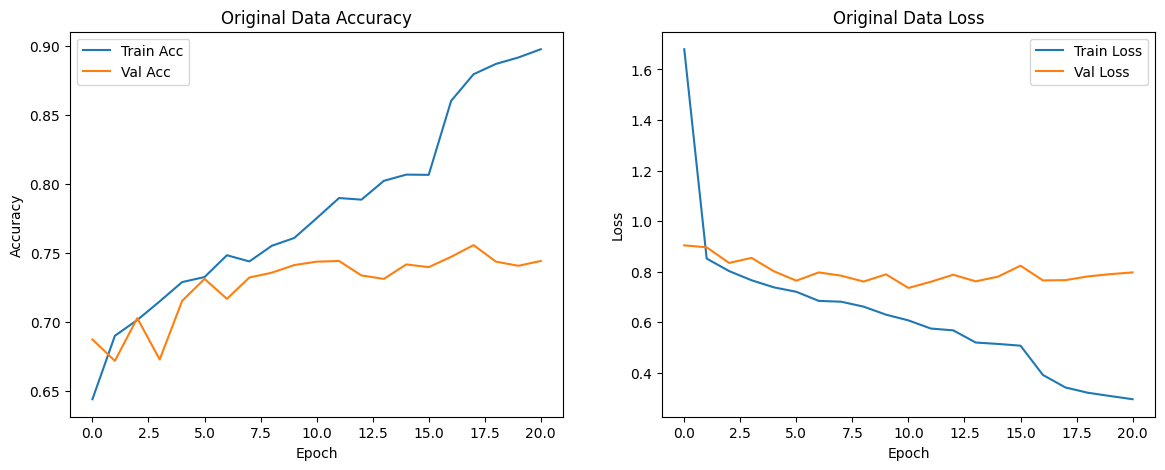

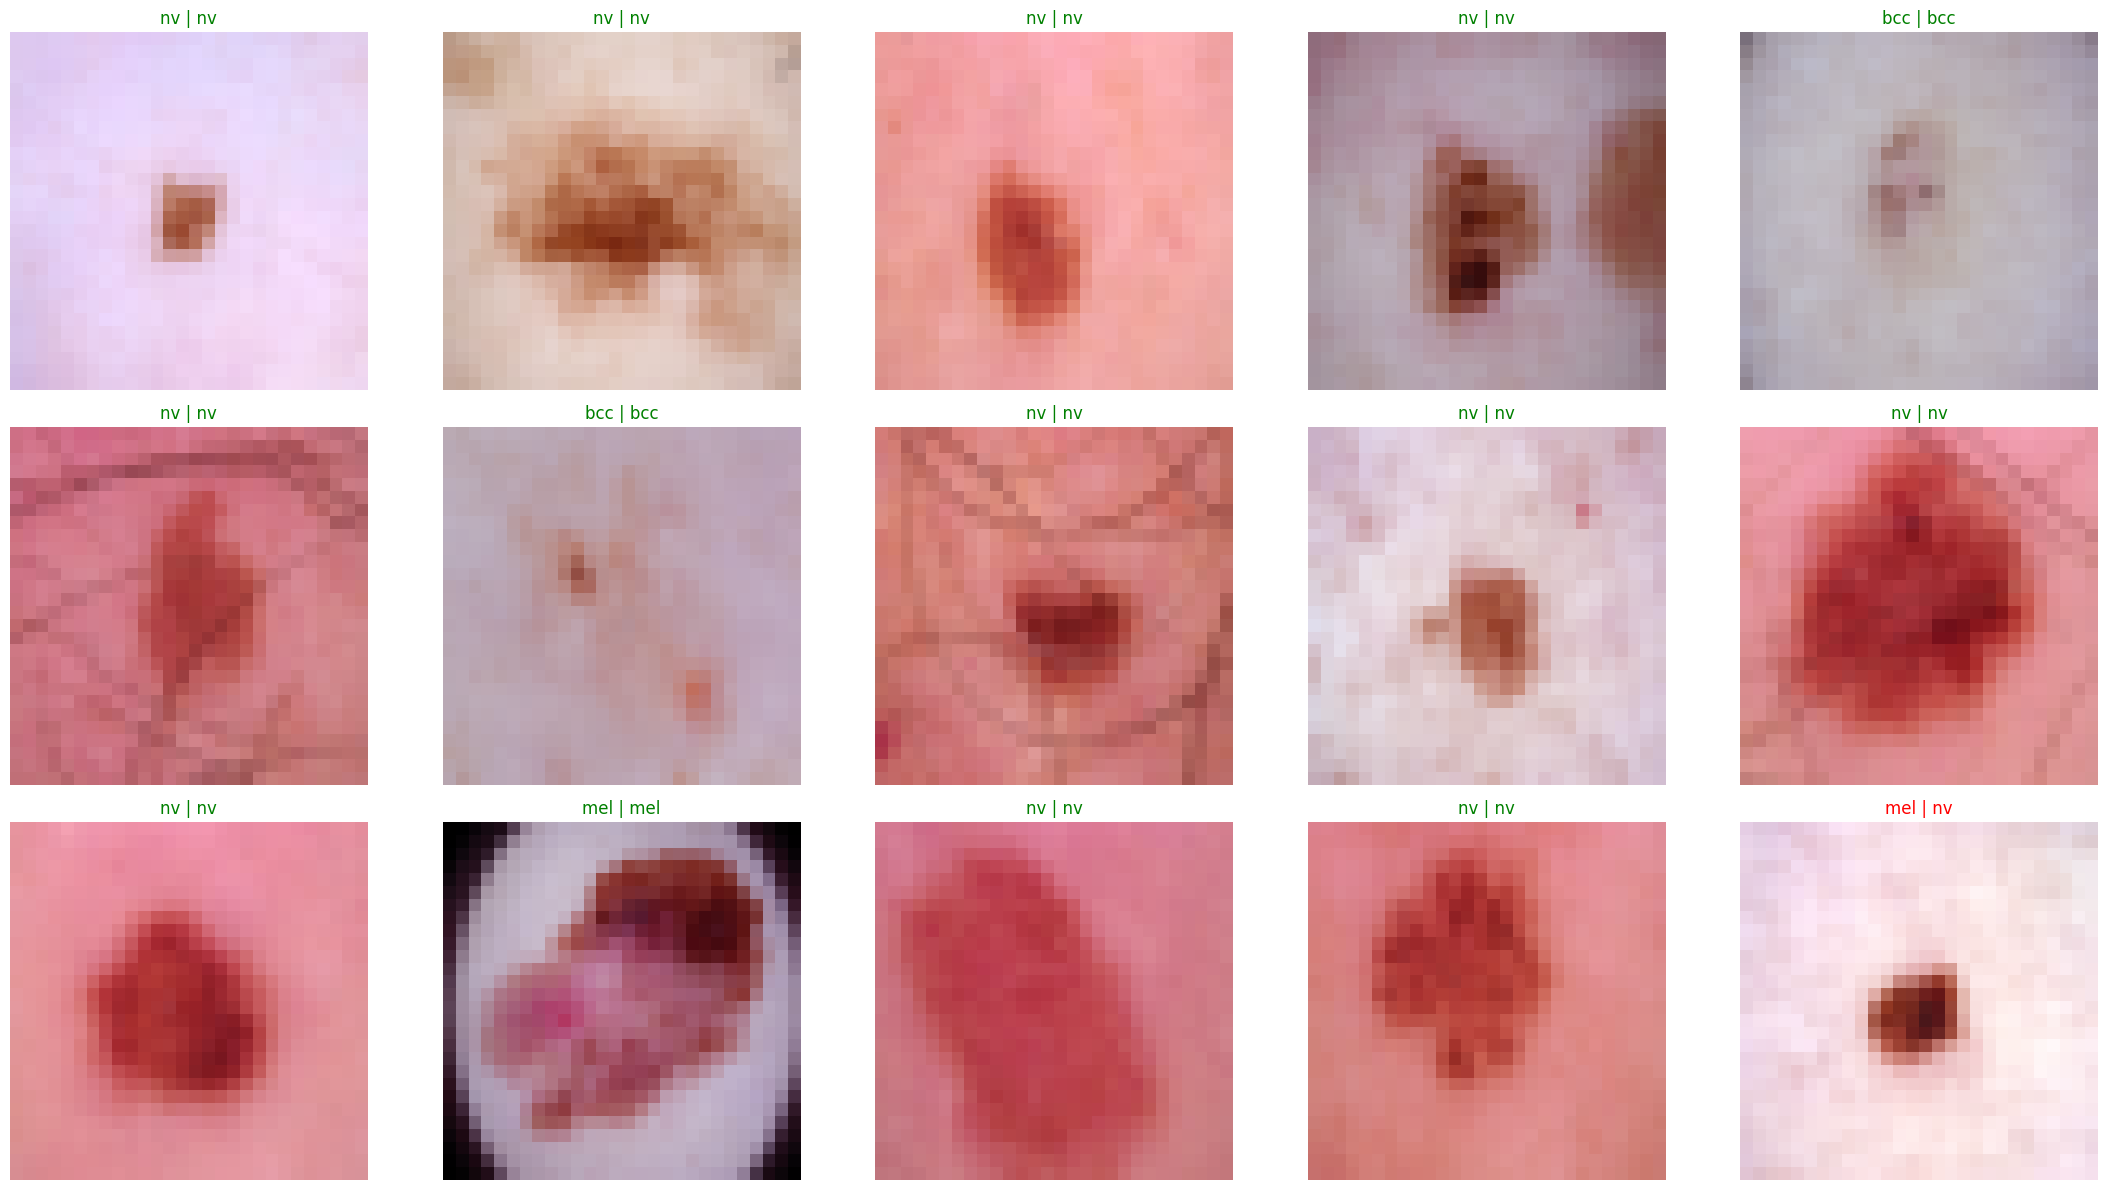

In [19]:
evaluate_and_visualize(model1, X_test, Y_test, history, title_prefix="Original Data")

In [20]:
# Prepare dataset
X_train_aug, X_val_aug, X_test_aug, Y_train_aug, Y_val_aug, Y_test_aug = prepare_for_train_valid_test(X_aug, Y_aug)

# Create model
model2 = create_model()

# Train model with explicit validation set
history_aug = train_model(model2, X_train_aug, Y_train_aug, X_val_aug, Y_val_aug, EPOCHS=40)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,583 (517.90 KB)

 Trainable params: 132,583 (517.90 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
429/429 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.2892 - loss: 3.1049 - val_accuracy: 0.5482 - val_loss: 1.1992 - learning_rate: 0.0010
Epoch 2/40
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5839 - loss: 1.0990 - val_accuracy: 0.6823 - val_loss: 0.8583 - learning_rate: 0.0010
Epoch 3/40
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7019 - loss: 0.8002 - val_accuracy: 0.7729 - val_loss: 0.6187 - learning_rate: 0.0010
Epoch 4/40
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7948 - loss: 0.5658 - val_accuracy: 0.8305 - val_loss: 0.4696 - learning_rate: 0.0010
Epoch 5/40
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8445 - loss: 0.4247 - val_accuracy: 0.8543 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 6/40
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8913 - loss: 0.2990 - val_accuracy: 0.8666 - val_loss: 0.3959 - learning_rate: 0.0010
Epoch 7/40
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9079 - loss: 0.2

Augmented Data Test Accuracy: 97.95%
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Augmented Data Classification Report:
              precision    recall  f1-score   support

          nv       0.99      0.87      0.93      1341
         mel       0.94      0.99      0.97      1336
         bkl       0.95      1.00      0.97      1319
         bcc       0.99      1.00      0.99      1336
       akiec       1.00      1.00      1.00      1243
        vasc       1.00      1.00      1.00      1335
          df       1.00      1.00      1.00      1242

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.98      9152



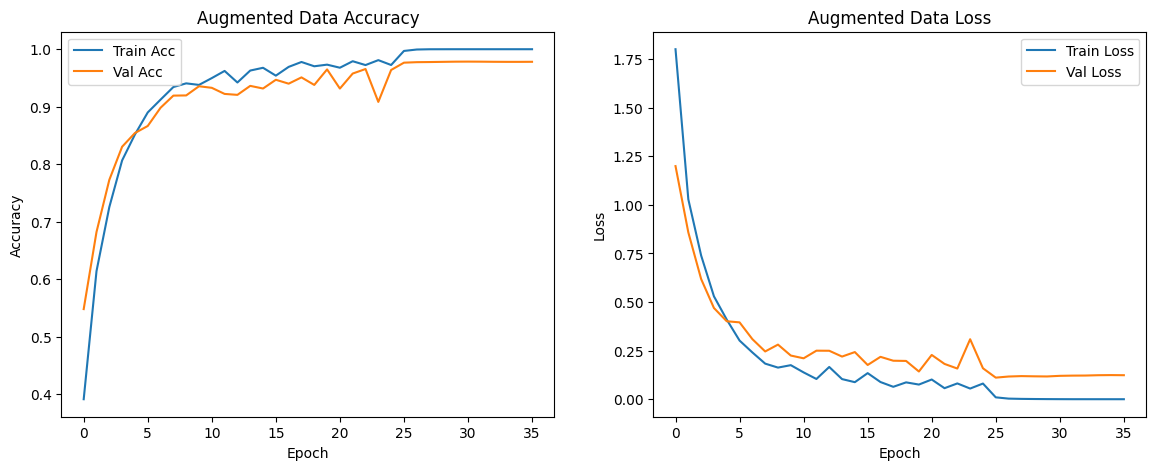

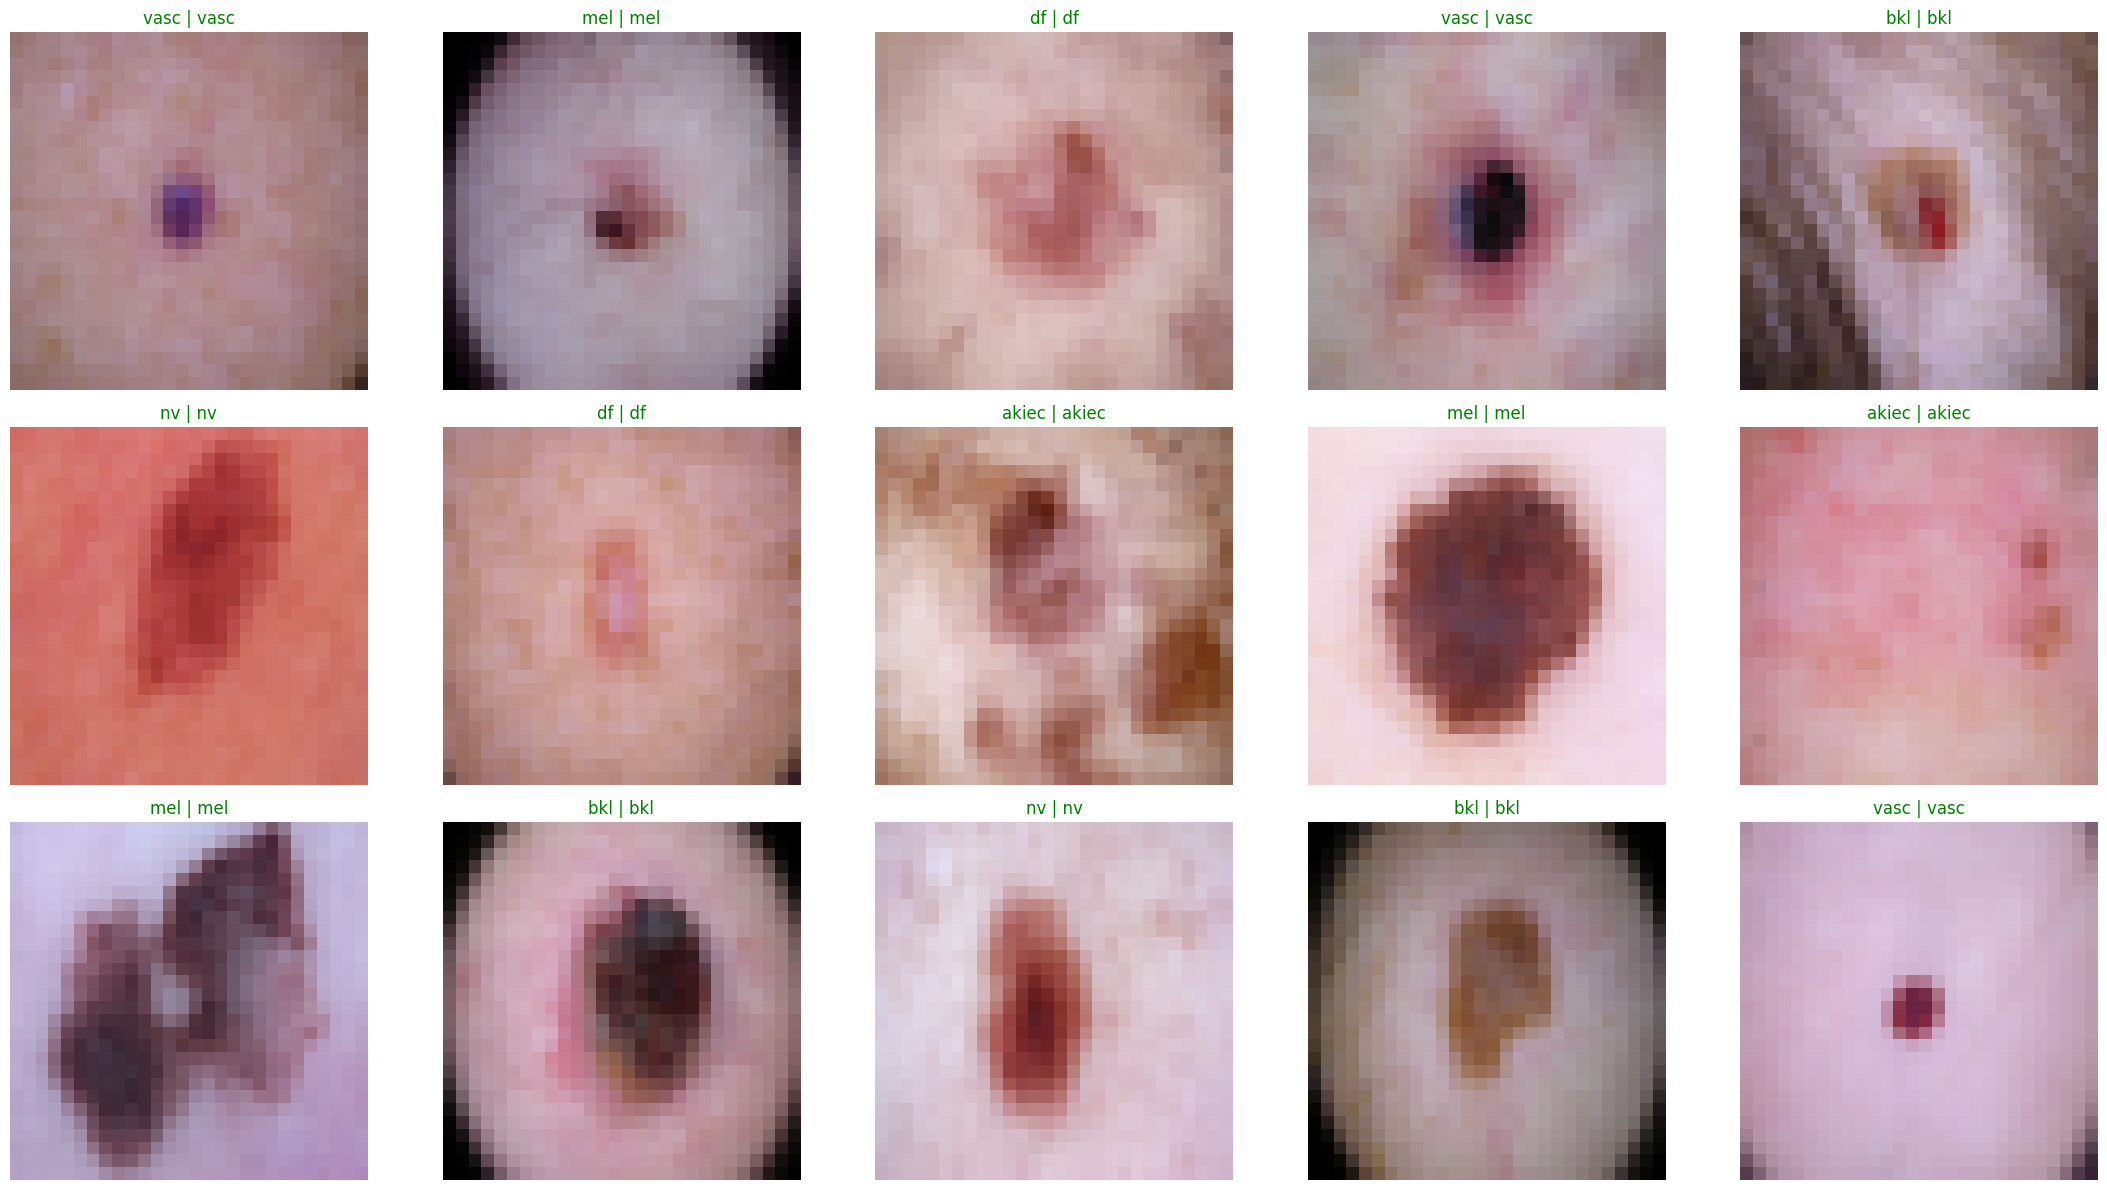

In [21]:
evaluate_and_visualize(model2, X_test_aug, Y_test_aug, history_aug, title_prefix="Augmented Data")

## Konversi Model

In [22]:
!pip install tensorflowjs
import tensorflowjs as tfjs

# Konversi ke format TensorFlow.js
tfjs.converters.save_keras_model(model2, 'tfjs_model')

# Untuk load di JavaScript:
# const model = await tf.loadLayersModel('path/to/model.json');

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file


In [23]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantization (untuk mengurangi ukuran model)
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

with open('model_quantized.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

Saved artifact at '/tmp/tmpl06wc4a6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name='keras_tensor_79')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  137882175526800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137882175524496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137882175526992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137882286182992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137882286184144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137882286183376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137882286182224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137882175542032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137882175545680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137882175541264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378821755416

In [24]:
import os

# Create the directory if it doesn't exist
os.makedirs('saved_model', exist_ok=True)

# Export ke SavedModel
model2.save('saved_model/my_model.keras')  # Added .keras extension
# Untuk memuat kembali:
loaded_model = tf.keras.models.load_model('saved_model/my_model.keras') # Updated loading method to use the same extension

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning:

Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 



## Inference (Optional)

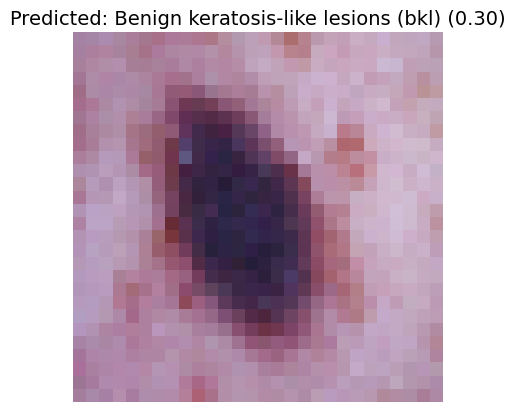

('Benign keratosis-like lesions (bkl)', np.float32(0.30351606))

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

label_mapping = {
    0: 'Melanocytic nevi (nv)',
    1: 'Melanoma (mel)',
    2: 'Benign keratosis-like lesions (bkl)',
    3: 'Basal cell carcinoma (bcc)',
    4: 'Actinic keratoses (akiec)',
    5: 'Vascular lesions (vasc)',
    6: 'Dermatofibroma (df)'
}

def preprocess_image_tflite(img_path, target_size=(28, 28)):
    """
    Memuat dan memproses gambar untuk model TFLite.
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)  # Tambahkan dimensi batch
    return img_array, img

def predict_with_tflite(model_path, img_path, label_mapping):
    """
    Melakukan inference dengan model TFLite dan menampilkan hasil prediksi.
    """
    # Load model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input/output detail
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocess input
    input_data, original_img = preprocess_image_tflite(img_path, target_size=tuple(input_details[0]['shape'][1:3]))

    # Inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    # Get prediction
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data[0])
    confidence = np.max(output_data[0])
    predicted_label = label_mapping[predicted_class]

    # Show result
    plt.imshow(original_img)
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f})", fontsize=14)
    plt.axis("off")
    plt.show()

    return predicted_label, confidence

# Contoh penggunaan:
img_path = "/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0033165.jpg"  # Data Uji
model_path = "model.tflite"
predict_with_tflite(model_path, img_path, label_mapping)
